# Movie Box Office revenue predictor


## Authors: Christopher Budd, Mustafa Syed, and Jayant Varma 

### Objective: 
To predict the revenue generated by a movie given its other features such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, etc.



**Dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing** Kindly download the dataset on your local machine and run it accordingly (see how we ran it under 'Loading the dataset')

# Movies daily updated dataset description:

**Attributes for the dataset:**
The below attributes are copied **AS IS** from the original dataset website https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data 

1. id	--> TMDB id

2. title	--> Title of the movie

3. genres	--> Genres are separated by'-'

4. original_language	--> The language the movie was made in

5. overview	    --> short description of movie

6. popularity   --> TMDB metric, in depth description can be found here, https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/discussion/400671 

7. production_companies	--> '-' separated production company

8. release_date     --> movie release date

9. budget	--> budget of the movie

10. revenue	    --> Revenue generated by the movie

11. runtime	    --> duration of the movie

12. status	--> status (Released, or planned, or other)

13. tagline	    --> tagline

14. vote_average	--> average of votes given by tmdb users

15. vote_count	       --> vote counts

16. credits	        --> '-' separated cast if movie

17. keywords	    --> '-' separated keywords that desciption of movie

18. poster_path	    --> poster image

19. backdrop_path	--> background images

20. recommendations --> '-' separated recommended movie id


**Missing values:** There exist missing values in multiple features of the above dataset as we'll soon see


**Duplicated values:** 
There exist duplicated values in multiple features of the above dataset as we'll soon see


# 1: Looking at the big picture, framing the problem, and business practicality

### Frame the problem
1. Supervised learning – training examples are labeled.
2. A regression task – predict a value (Revenue).
3. Batch learning 
    - Small data set
    - No continuous flow of data coming into the system
    - No need to adjust to changing data rapidly

### Big Picture/Business objective:
At the end of the day every business wants to know how much revenue they can generate given the all production inputs. Our project solves this problem for the movie industry. See objective below.

### Objective: 
To predict the revenue generated by a movie given its other featuers such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, and recommendations.


# Initial set up

In [50]:
# Import libraries

import sklearn
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [51]:
movies = pd.read_csv(".\modified_data.csv") 
# Please note: The file is massive, and could not be referred online. You MUST download the file on your local machine from https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=drive_link (MAKE SURE YOU ONLY USE YOUR YORK UNIVERSITY GOOGLE ACCOUNT!!!)

# 2 First impressions on the dataset, graphs of the EDA, and patterns found


Note: We use only the dataset from January 1st 2015 until Nov. 5th 2023

In [52]:
# Convert 'release_date' to datetime format
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Create a mask for filtering dates
mask = (movies['release_date'] >= '2015-01-01') & (movies['release_date'] <= '2023-11-05')

# Apply the mask to filter rows
movies = movies[mask]

# # Sort the DataFrame based on 'release_date'
# movies = movies.sort_values(by='release_date', ascending=False)

In [53]:
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000,352056482,116.0,Released,Back for seconds.,7.079,1365,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000,65675816,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000,407045464,127.0,Released,Unite or fall.,7.340,1007,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000,475766228,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000,269000000,116.0,Released,You can't run from your past.,7.262,1129,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231526,712436,"Ensemble, pour Noël !",Family-Comedy,fr,NaN,0.600,Productions Déferlantes,2017-12-10,0,0,0.0,Released,NaN,0.000,0,Marc Dupré-Brigitte Boisjoli-Paul Daraîche-Mar...,NaN,NaN,NaN,NaN
231527,358921,A Journey of a Thousand Miles: Peacekeepers,Documentary,en,A Journey of a Thousand Miles: Peacekeepers ac...,0.600,G2P2 Films-Women Make Movies-JustFilms / Ford ...,2015-11-14,0,0,95.0,Released,NaN,0.000,0,NaN,woman director,NaN,NaN,NaN
231528,555347,Nazli,Drama,fa,The story of an old love and living in a warm ...,0.600,NaN,2015-10-21,10000,100000,85.0,Released,NaN,0.000,0,Omid Zendegani-Leila Otadi-Mehran Rajabi-Rahim...,NaN,/crJvsFmKpMSrwS4QoYX1td6c5hE.jpg,NaN,NaN
231529,576855,Stastriptease,NaN,de,NaN,0.600,NaN,2018-06-07,0,0,NaN,Released,NaN,0.000,0,NaN,NaN,NaN,NaN,NaN


#### Use head() to look at the first 5 rows

In [54]:
movies.head()


,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000,352056482,116.0,Released,Back for seconds.,7.079,1365,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000,65675816,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000,407045464,127.0,Released,Unite or fall.,7.340,1007,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000,475766228,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000,269000000,116.0,Released,You can't run from your past.,7.262,1129,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...


#### Use describe() method to see a summary of the numerical attributes.


Note: 
- Since count of id = count of budget and count of revenue, we know our data for predicting revenue is complete in a one to one mapping between id and revenue. The data rows exist, however the values may need preprocessing
- Parts of this data make little sense, for example, the maximum run time is 1.5 years if we take the unit to be in seconds. This clearly means, a lot of data cleaning, and preprocessing is required. Since 75% of movies are 90 time units long, we will arbitrarily take 150 units as the maximum length allowed, and delete all instances that run longer than this. (see preprocessing).
- Revenue could be negative, as seen from the 'min' case.

In [55]:
movies.describe()

,id,popularity,release_date,budget,revenue,runtime,vote_average,vote_count
count,231531.000000,231531.000000,231531,2.315310e+05,2.315310e+05,225962.000000,231531.000000,231531.000000
mean,661458.030950,2.560032,2018-12-05 22:32:46.316389632,3.512270e+05,9.489644e+05,50.819664,2.560550,26.624137
min,10148.000000,0.600000,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,521855.000000,0.600000,2017-03-04 00:00:00,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000
50%,665913.000000,0.621000,2019-01-01 00:00:00,0.000000e+00,0.000000e+00,37.000000,0.000000,0.000000
75%,806401.000000,1.400000,2020-09-28 00:00:00,0.000000e+00,0.000000e+00,90.000000,6.000000,2.000000
max,968149.000000,8763.998000,2023-11-05 00:00:00,5.400000e+08,2.799439e+09,43200.000000,10.000000,28462.000000
std,176614.846096,36.128391,NaN,6.059478e+06,2.396668e+07,107.824413,3.339721,373.046485


#### Use info() to get a quick description of the data, the total number of rows, each attribute’s type, and the number of non-null values.

In [56]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231531 entries, 0 to 231530
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    231531 non-null  int64         
 1   title                 231530 non-null  object        
 2   genres                177604 non-null  object        
 3   original_language     231531 non-null  object        
 4   overview              199719 non-null  object        
 5   popularity            231531 non-null  float64       
 6   production_companies  106563 non-null  object        
 7   release_date          231531 non-null  datetime64[ns]
 8   budget                231531 non-null  int64         
 9   revenue               231531 non-null  int64         
 10  runtime               225962 non-null  float64       
 11  status                231531 non-null  object        
 12  tagline               37889 non-null   object        
 13 

In [57]:
corr_matrix = movies.corr(numeric_only=True)
corr_matrix

,id,popularity,budget,revenue,runtime,vote_average,vote_count
id,1.000000,-0.009823,-0.076756,-0.059612,-0.118946,-0.290103,-0.096509
popularity,-0.009823,1.000000,0.245424,0.180780,0.023105,0.054221,0.127252
budget,-0.076756,0.245424,1.000000,0.737858,0.036710,0.068093,0.673959
revenue,-0.059612,0.180780,0.737858,1.000000,0.026164,0.052281,0.749597
runtime,-0.118946,0.023105,0.036710,0.026164,1.000000,0.133944,0.040572
vote_average,-0.290103,0.054221,0.068093,0.052281,0.133944,1.000000,0.091140
vote_count,-0.096509,0.127252,0.673959,0.749597,0.040572,0.091140,1.000000


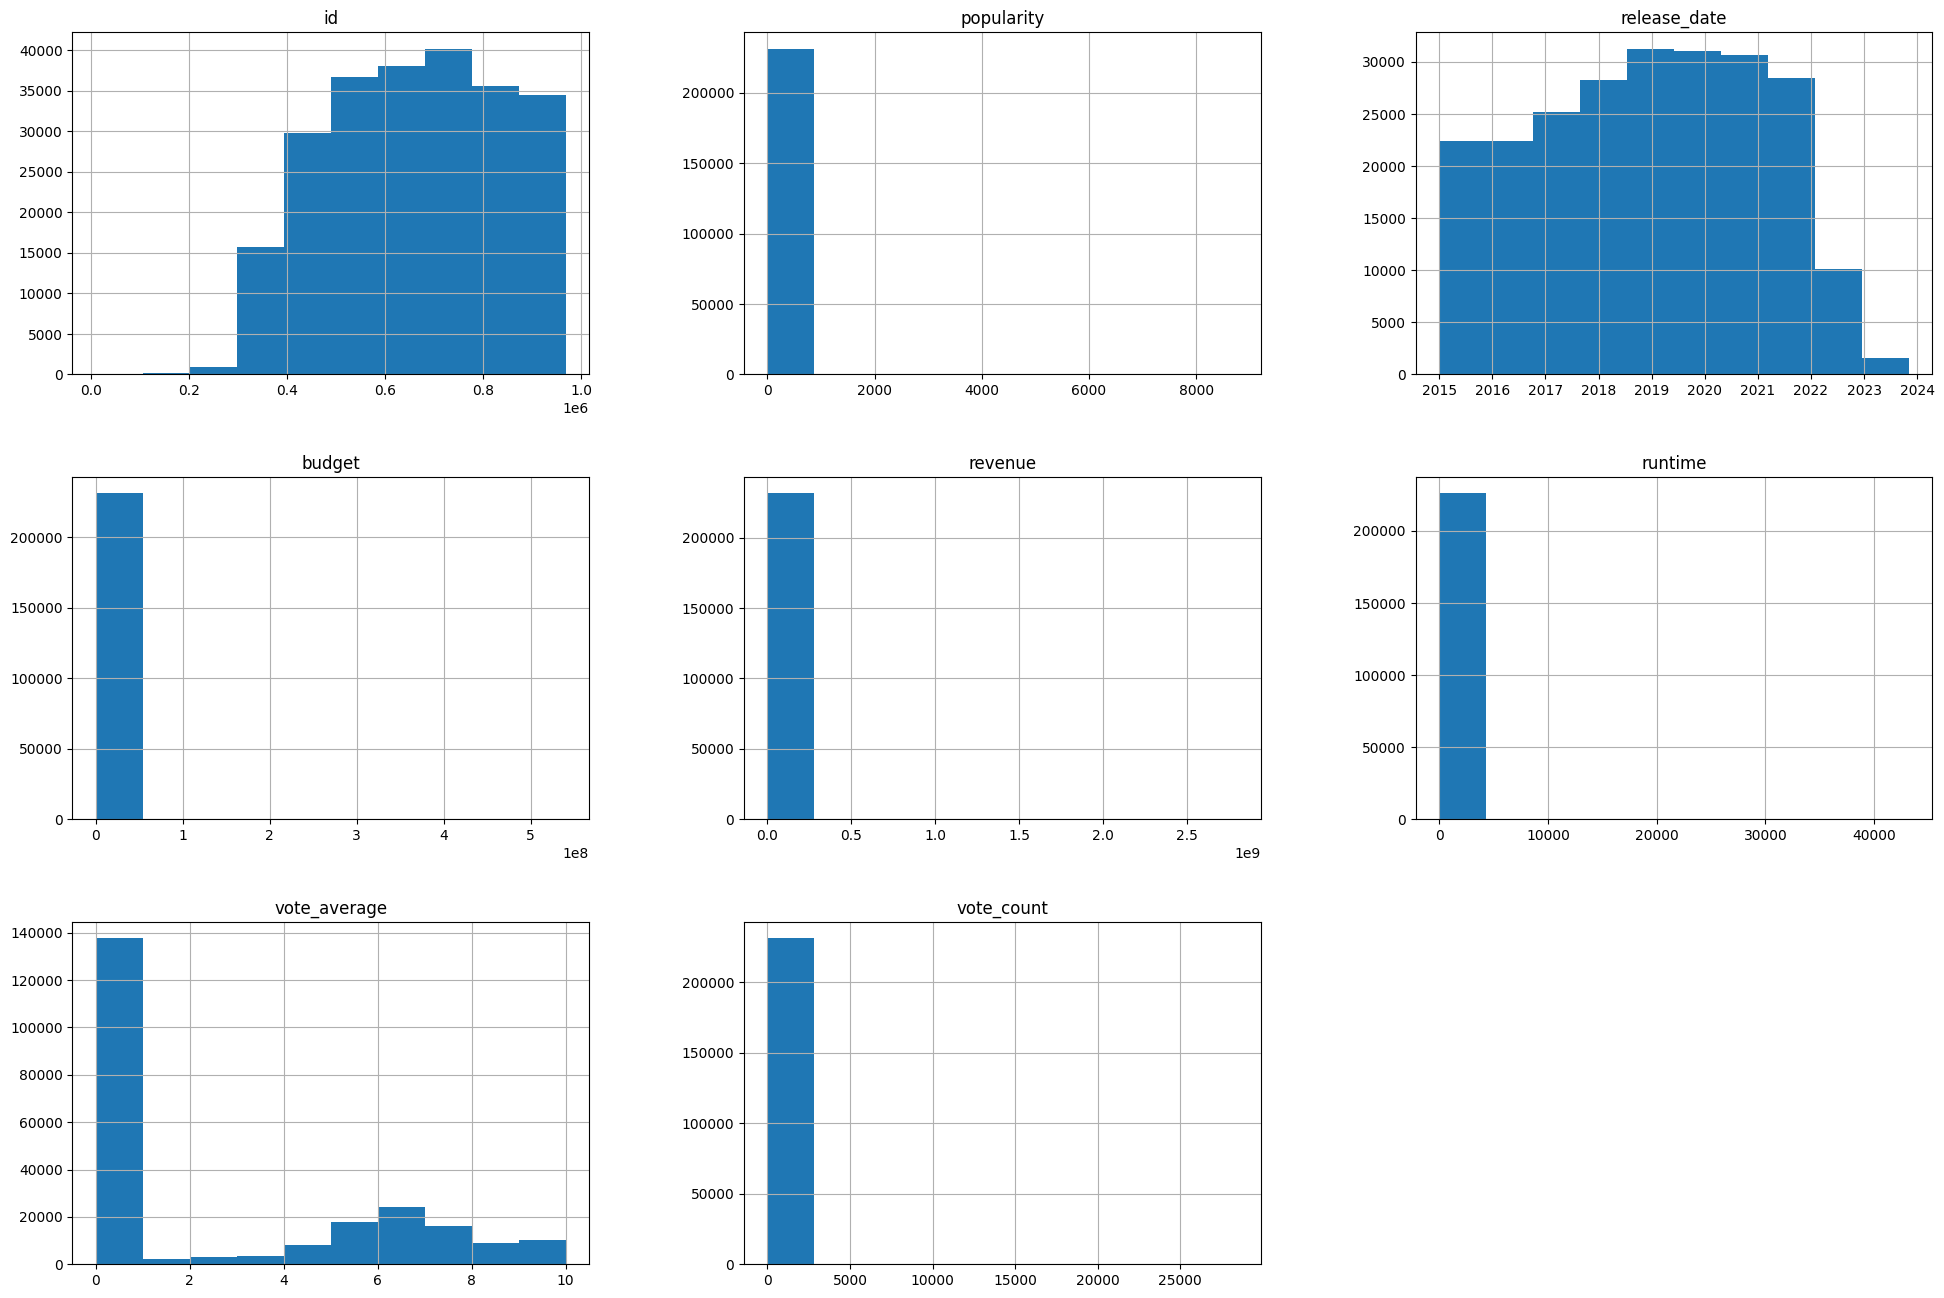

In [58]:
movies.hist(figsize=(24, 16))
plt.show()

In [59]:
# Check for correlation between attributes using sns.pairplot.
# sns.pairplot(movies)  # isn't working for some reason, think on this later

### Curious note: Usually, one may presume that the greater the budget of the movie, the better revenue it may generate. So let's put this to the test:

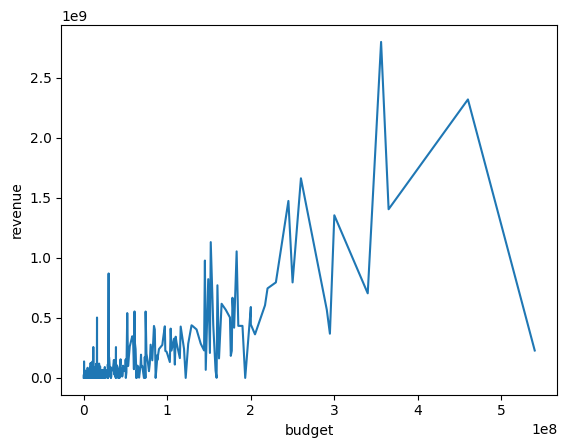

In [60]:
# Plot budget vs. revenue generated

budgetVsRevenue = sns.lineplot(x="budget", y="revenue", data=movies, errorbar=None)

Observation: As you can see, it is not necessarily the case that higher the budget, the more revenue is generated. For better visualization, we must clean this data to scale the x-axis (i.e., budget) to better see the correlation

Text(0, 0.5, 'revenue')

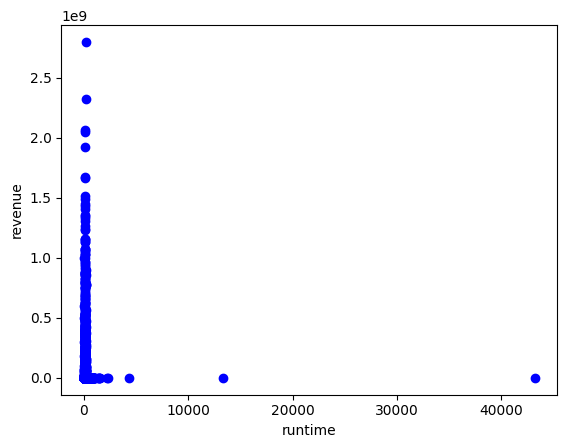

In [61]:
x_axis = movies["runtime"]
y_axis = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

Observation: clearly, we need to get rid of the right most value as it is ruining the data plot. We need feature scaling after that. 
### Check the data cleaning part, we have removed the outliers by using a threshold for our movie runtime. We plot this graph again for better interpretations.

# 3 Preprocessing: Preparing data for Machine Learning tasks


## 3.1. - Data cleaning

Recall from above, that one runtime value is extraordinarily big. We will remove this outlier now.

In [62]:
# Assuming the threshold for high runtime is 150 units
threshold_runtime = 150

# Create a boolean mask indicating which rows have runtime below or equal to the threshold
mask = movies['runtime'] <= threshold_runtime

# now, our dataframe contains only the rows with runtime below or equal to the threshold
movies = movies[mask]



Text(0, 0.5, 'revenue')

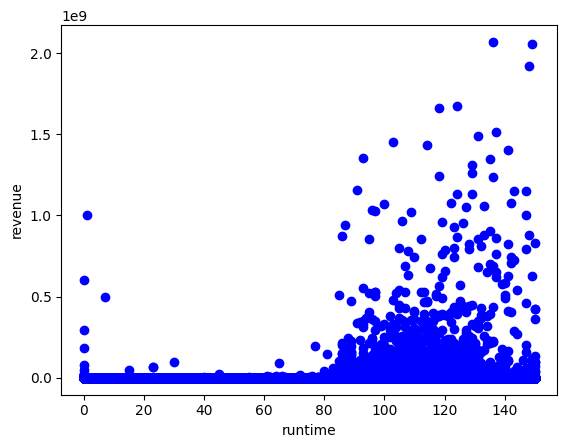

In [63]:
# We now show how our earlier plot becomes so much better:

x_axis = movies["runtime"]
y_axis = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(x_axis, y_axis, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

3.1.1-  Checking for duplicates, and dropping them:

In [64]:
movies.duplicated().sum()

0

In [65]:
movies.drop_duplicates(inplace=True)

3.1.2 - Handle the missing values:

In [66]:
# Find the number of missing values in each column as a fraction out of total instances

movies.isna().sum()/len(movies)

id                      0.000000
title                   0.000005
genres                  0.227816
original_language       0.000000
overview                0.126002
popularity              0.000000
production_companies    0.538411
release_date            0.000000
budget                  0.000000
revenue                 0.000000
runtime                 0.000000
status                  0.000000
tagline                 0.833529
vote_average            0.000000
vote_count              0.000000
credits                 0.307068
keywords                0.702956
poster_path             0.129622
backdrop_path           0.575128
recommendations         0.940133
dtype: float64

Since, the 'recommendations' feature is nearly empty, its best that we drop it. Similarly, we'll drop 'tagline', 'backdrop_path', 'keywords', and 'production_companies'. We chose the threshold to be that if the feature is more than 50% empty, it will be entirely dropped.

In [67]:
movies.drop(labels=['recommendations'], axis=1, inplace=True)
movies.drop(labels=['tagline'], axis=1, inplace=True)
movies.drop(labels=['keywords'], axis=1, inplace=True)
movies.drop(labels=['backdrop_path'], axis=1, inplace=True)
movies.drop(labels=['production_companies'], axis=1, inplace=True)

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221775 entries, 0 to 231530
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 221775 non-null  int64         
 1   title              221774 non-null  object        
 2   genres             171251 non-null  object        
 3   original_language  221775 non-null  object        
 4   overview           193831 non-null  object        
 5   popularity         221775 non-null  float64       
 6   release_date       221775 non-null  datetime64[ns]
 7   budget             221775 non-null  int64         
 8   revenue            221775 non-null  int64         
 9   runtime            221775 non-null  float64       
 10  status             221775 non-null  object        
 11  vote_average       221775 non-null  float64       
 12  vote_count         221775 non-null  int64         
 13  credits            153675 non-null  object       

Removing Unimport Fields

In [68]:
# movies.drop(labels=['id'], axis=1, inplace=True)
movies.drop(labels=['overview'], axis=1, inplace=True)
movies.drop(labels=['status'], axis=1, inplace=True)
movies.drop(labels=['poster_path'], axis=1, inplace=True)
movies.drop(labels=['credits'], axis=1, inplace=True)
movies.drop(labels=['original_language'], axis=1, inplace=True)
movies.drop(labels=['title'], axis=1, inplace=True)
movies.drop(labels=['release_date'], axis=1, inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221775 entries, 0 to 231530
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            221775 non-null  int64  
 1   genres        171251 non-null  object 
 2   popularity    221775 non-null  float64
 3   budget        221775 non-null  int64  
 4   revenue       221775 non-null  int64  
 5   runtime       221775 non-null  float64
 6   vote_average  221775 non-null  float64
 7   vote_count    221775 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 15.2+ MB


#### For the remaining missing values, we will fill them with the mean if it is a numerical value and the most frequent if it is a categorical column

#### We will do this through creating a pipeline, that will also scale the features and perform encoding in the next step.

### 3.1.3 Creating a pipeline that will:

1. Fill in the missing numerical values with the mean using a SimpleImputer

2. Scale the numerical columns using StandardScaler. Do not scale the target

3. Fill in the missing categorical values with the most_frequent value using SimpleImputer

4. Encode the categorical columns using OneHotEncoder


In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [70]:
# Create the cat and num columns
# Get a list of column names from the 'movies' DataFrame that are of numerical data types.
# Get a list of column names from the 'movies' DataFrame that are not of numerical data types.

num_cols = movies.select_dtypes(include='number').columns.to_list()
cat_cols = movies.select_dtypes(exclude='number').columns.to_list()


# Exclude the target from numerical columns
num_cols.remove("revenue")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),  OneHotEncoder(sparse_output=False))

# Use ColumnTransformer to set the estimators and transformations

preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [71]:
num_cols

['id', 'popularity', 'budget', 'runtime', 'vote_average', 'vote_count']

In [72]:
cat_cols

['genres']

In [73]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['id', 'popularity', 'budget', 'runtime',
                                  'vote_average', 'vote_count']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['genres'])])

In [74]:
# # Apply the preprocessing pipeline on the dataset                 # UNCOMMENT AND FIX THIS ERROR. THERE'S AN ERROR HERE.

movies_prepared = preprocessing.fit_transform(movies)

# # Scikit-learn strips the column headers, so just add them back on afterwards
feature_names=preprocessing.get_feature_names_out()
movies_prepared = pd.DataFrame(data=movies_prepared, columns=feature_names)

movies_prepared

,num__id,num__popularity,num__budget,num__runtime,num__vote_average,num__vote_count,cat__genres_Action,cat__genres_Action-Action-Thriller,cat__genres_Action-Adventure,cat__genres_Action-Adventure-Animation,...,cat__genres_Western-Mystery,cat__genres_Western-Mystery-Drama-Music,cat__genres_Western-Mystery-Thriller-Drama,cat__genres_Western-Romance,cat__genres_Western-Romance-Action-Comedy,cat__genres_Western-Science Fiction,cat__genres_Western-TV Movie,cat__genres_Western-Thriller,cat__genres_Western-War-Adventure-History-Science Fiction-Animation,remainder__revenue
0,-0.282200,238.403355,22.537773,1.588113,1.351763,3.652139,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352056482.0
1,0.524622,161.920590,3.094881,1.286478,1.457946,1.414636,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65675816.0
2,0.011207,147.114677,34.974218,1.843342,1.430050,2.675278,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,407045464.0
3,-0.143703,120.347147,34.974218,1.796936,1.180189,7.597786,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475766228.0
4,0.065729,108.618154,13.079069,1.588113,1.406654,3.008175,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221770,-1.470878,-0.053961,-0.058021,0.752817,-0.771604,-0.072486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221771,0.265118,-0.053961,-0.058021,-1.103396,-0.771604,-0.072486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221772,-1.734109,-0.053961,-0.058021,1.100857,-0.771604,-0.072486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221773,-0.623265,-0.053961,-0.056269,0.868830,-0.771604,-0.072486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000.0


## 3.3. - Feature scaling

# 4 Training and evaluation of 3 Machine Learning Algorithms, findings, and result comparison

## 4.1 Training Split

In [75]:
from sklearn.model_selection import train_test_split
X = movies_prepared
y = movies["revenue"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(177420, 5146) (177420,) (44355, 5146) (44355,)


## 4.1. - Training of 3 ML algorithms
- Algorithm 1: LinearRegression no regularization
- Algorithm 2:
- Algorithm 3: RandomForestRegressor

### Algorithm 1: Linear Regression no regularization

In [76]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [77]:
lr_y_predict = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse
lr_mse=mse(y_test, lr_y_predict)
lr_mse

1.8694628245294625e-11

### Algorthm 3 RandomForestRegressor

In [78]:
from sklearn.ensemble import RandomForestRegressor
rfr_model = (max_depth=10, min_samples_split=5, random_state = 10, 
            n_estimators=500)
scores = cross_val_score(rfr_model, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2135384881.py, line 2)

## 4.2. - Analysis of findings



## 4.3. - Comparison of results

# 5 - Three Graphs for the best performance algorithm

# 6 Limitations of the project

# Appendix 1:

Empty unless we used someone else's code, then we cite it here

# Appendix 2: 

### Github repository link: https://github.com/Jayant1Varma/Movie-Box-Office-predictor.git 

**Original dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing**